In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import chakin

from collections import defaultdict
import nltk
from nltk.tokenize import TreebankWordTokenizer

import re
nltk.download('stopwords')

import json
import zipfile

C:\Users\pandu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pandu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pandu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pandu\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
chakin.search(lang='English')

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [3]:
RANDOM_SEED = 42
REMOVE_STOPWORDS=False
EVOCABSIZE=10000
DATA_FOLDER="embeddings"

data_Obj=json.dumps({
    "file_list" : ['50d','100d'],
    "file_text": 'txt',
    "file_data":
    [
         {
            "CHAKIN_INDEX" : 18,
            "NUMBER_OF_DIMENSIONS" : 50,
            "SUBFOLDER_NAME" : "Twitter",
            "EMBEDDINGS_FILE" : "glove.Twitter.27B",
            "REVIEWS_POS":"twitter_positive",
            "REVIEWS_NEG":"twitter_negative"
        },
        {
            "CHAKIN_INDEX" : 11,
            "NUMBER_OF_DIMENSIONS" : 50,
            "SUBFOLDER_NAME" : "Movie_Reviews",
            "EMBEDDINGS_FILE" : "glove.6B",
            "REVIEWS_POS":"movie_reviews_positive",
            "REVIEWS_NEG":"movie_reviews_negative"
        }
    ]
})


In [4]:
input_data_Obj=json.loads(data_Obj)

In [5]:
for data in input_data_Obj["file_data"]:
    ZIP_FILE=os.path.join(DATA_FOLDER,"{}.zip".format(data["EMBEDDINGS_FILE"]))
    ZIP_FILE_ALT="glove" + ZIP_FILE[5:]
    UNZIP_FOLDER=os.path.join(DATA_FOLDER,data["SUBFOLDER_NAME"])
    if not os.path.exists(UNZIP_FOLDER):
        chakin.download(number=data["CHAKIN_INDEX"],save_dir='./{}'.format(DATA_FOLDER))
        with zipfile.ZipFile(ZIP_FILE,"r") as zip_ref:
            zip_ref.extractall(UNZIP_FOLDER)

In [6]:
def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    """
    Read a embeddings txt file. If `with_indexes=True`, 
    we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, 
    otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping 
    from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
  
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r', encoding='utf-8') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict


In [7]:
embeddings_filename=os.path.join(DATA_FOLDER,input_data_Obj["file_data"][1]["SUBFOLDER_NAME"],"{}.300d.txt".format(input_data_Obj["file_data"][1]["EMBEDDINGS_FILE"]))
print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = \
    load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from embeddings\Movie_Reviews\glove.6B.300d.txt
Embedding loaded from disks.


In [8]:
vocab_size, embedding_dim = index_to_embedding.shape
print("Embedding is of shape: {}".format(index_to_embedding.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend occur more often.")

print("Note: for unknown words, the representation is an empty vector,\n"
      "and the index is the last one. The dictionnary has a limit:")
print("    {} --> {} --> {}".format("A word", "Index in embedding", 
      "Representation"))
word = "worsdfkljsdf"  # a word obviously not in the vocabulary
idx = word_to_index[word] # index for word obviously not in the vocabulary
complete_vocabulary_size = idx 
embd = list(np.array(index_to_embedding[idx], dtype=int)) # "int" compact print
#print("    {} --> {} --> {}".format(word, idx, embd))
word = "the"
idx = word_to_index[word]
embd = list(index_to_embedding[idx])  # "int" for compact print only.
#print("    {} --> {} --> {}".format(word, idx, embd))

Embedding is of shape: (400001, 300)
This means (number of words, number of dimensions per word)

The first words are words that tend occur more often.
Note: for unknown words, the representation is an empty vector,
and the index is the last one. The dictionnary has a limit:
    A word --> Index in embedding --> Representation


In [9]:
# This is a famous typing exercise with all letters of the alphabet
# https://en.wikipedia.org/wiki/The_quick_brown_fox_jumps_over_the_lazy_dog
a_typing_test_sentence = 'The quick brown fox jumps over the lazy dog'
print('\nTest sentence: ', a_typing_test_sentence, '\n')
words_in_test_sentence = a_typing_test_sentence.split()

print('Test sentence embeddings from complete vocabulary of', 
      complete_vocabulary_size, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = index_to_embedding[word_to_index[word_]]
    print(word_ + ": ", embedding)


Test sentence:  The quick brown fox jumps over the lazy dog 

Test sentence embeddings from complete vocabulary of 400000 words:

the:  [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01

In [10]:
# Define vocabulary size for the language model    
# To reduce the size of the vocabulary to the n most frequently used words

def default_factory():
    return EVOCABSIZE  # last/unknown-word row in limited_index_to_embedding
# dictionary has the items() function, returns list of (key, value) tuples
limited_word_to_index = defaultdict(default_factory, \
    {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})

# Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
# Set the unknown-word row to be all zeros as previously
limited_index_to_embedding = np.append(limited_index_to_embedding, 
    index_to_embedding[index_to_embedding.shape[0] - 1, :].\
        reshape(1,embedding_dim), 
    axis = 0)

# Delete large numpy array to clear some CPU RAM
del index_to_embedding

num_rep={}
# Verify the new vocabulary: should get same embeddings for test sentence
# Note that a small EVOCABSIZE may yield some zero vectors for embeddings
print('\nTest sentence embeddings from vocabulary of', EVOCABSIZE, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = limited_index_to_embedding[limited_word_to_index[word_]]
    num_rep[word]=embedding
    print(word_ + ": ", embedding)


Test sentence embeddings from vocabulary of 10000 words:

the:  [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-0

In [11]:
words_in_test_sentence

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

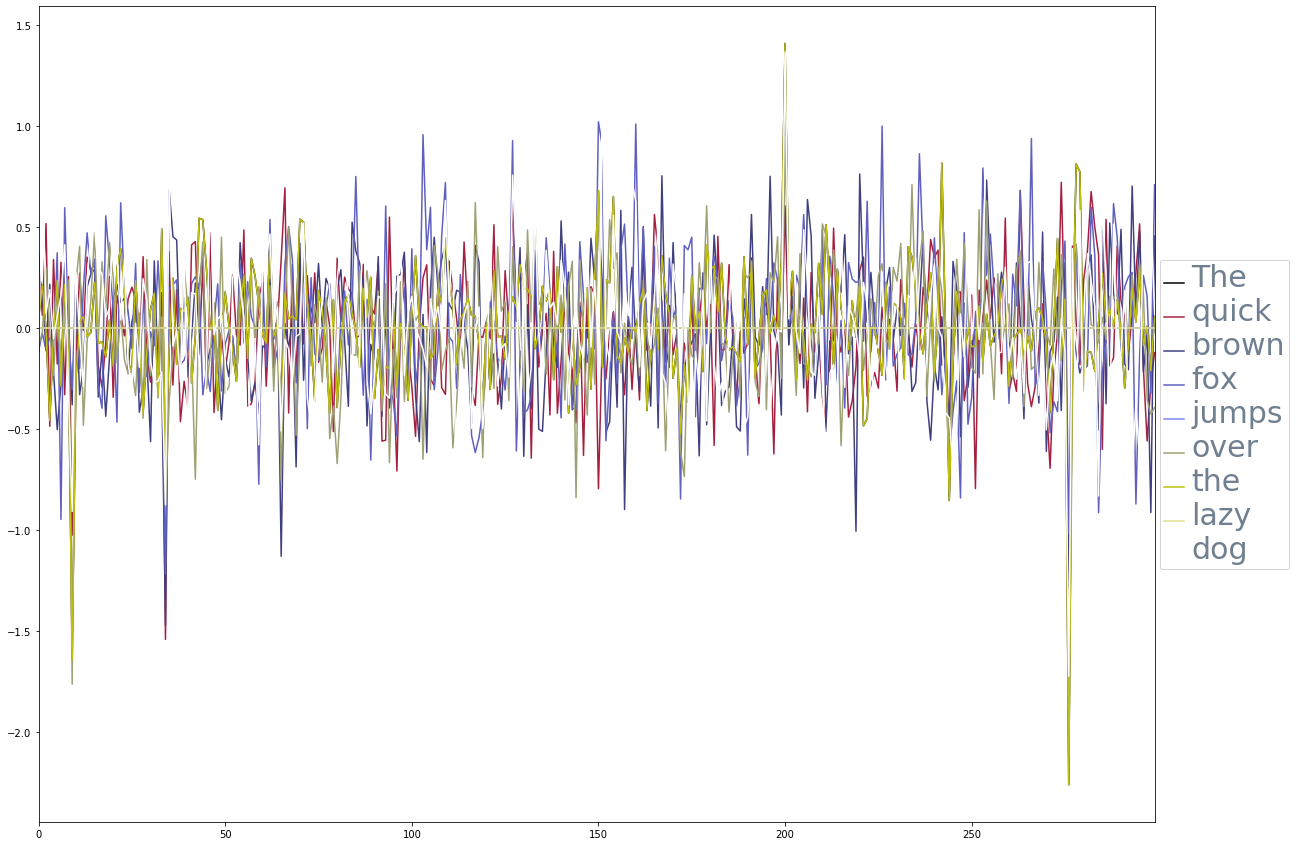

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

numeric_df = pd.DataFrame.from_dict(num_rep)
fig, ax = plt.subplots()
fig.patch.set_alpha(0.9)
numeric_df.plot(kind='line',legend = True, colormap='gist_stern', figsize=(20,15), ax = ax)
#ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.9)

leg = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

for text in leg.get_texts():
    plt.setp(text, color = 'slategrey')
    plt.setp(text, size = 30)
        
plt.show()

In [13]:
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file)
    return(end_list)

In [14]:
# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']   

# We will not remove stopwords in this exercise because they are
# important to keeping sentences intact
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words('english'))

# previous analysis of a list of top terms showed a number of words, along 
# with contractions and other word strings to drop from further analysis, add
# these to the usual English stopwords to be dropped from a document collection
    more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs'] 

    some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
        'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
        'toni','welles','william','wolheim','nikita']

    # start with the initial list and add to it for movie text work 
    stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
        some_proper_nouns_to_remove

In [15]:
# text parsing function for creating text documents 
# there is more we could do for data preparation 
# stemming... looking for contractions... possessives... 
# but we will work with what we have in this parsing function
# if we want to do stemming at a later time, we can use
#     porter = nltk.PorterStemmer()  
# in a construction like this
#     words_stemmed =  [porter.stem(word) for word in initial_words] 
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)

In [16]:
def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

In [17]:
#positive reviews
dir_name=os.path.join(DATA_FOLDER,input_data_Obj["file_data"][1]["SUBFOLDER_NAME"],input_data_Obj["file_data"][1]["REVIEWS_POS"]) 
print(dir_name)
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))

# Read data for positive movie reviews
# Data will be stored in a list of lists where the each list 
# represents a document and document is a list of words.
# We then break the text into words.

positive_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    positive_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))

embeddings\Movie_Reviews\movie_reviews_positive

Directory: embeddings\Movie_Reviews\movie_reviews_positive
500 files found

Processing document files under embeddings\Movie_Reviews\movie_reviews_positive


In [18]:
#negative reviews
dir_name=os.path.join(DATA_FOLDER,input_data_Obj["file_data"][1]["SUBFOLDER_NAME"],input_data_Obj["file_data"][1]["REVIEWS_NEG"]) 
print(dir_name)
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))

# Read data for positive movie reviews
# Data will be stored in a list of lists where the each list 
# represents a document and document is a list of words.
# We then break the text into words.

negative_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    negative_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))

embeddings\Movie_Reviews\movie_reviews_negative

Directory: embeddings\Movie_Reviews\movie_reviews_negative
500 files found

Processing document files under embeddings\Movie_Reviews\movie_reviews_negative


In [19]:
# -----------------------------------------------------
# convert positive/negative documents into numpy array
# note that reviews vary from 22 to 1052 words   
# so we use the first 20 and last 20 words of each review 
# as our word sequences for analysis
# -----------------------------------------------------
max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))    
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
print('max_review_length:', max_review_length) 

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 
print('min_review_length:', min_review_length) 

# construct list of 1000 lists with 20 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)
    
#embeddings

max_review_length: 1052
min_review_length: 22


In [20]:
# -----------------------------------------------------    
# Check on the embeddings list of list of lists 
# -----------------------------------------------------
# Show the first word in the first document
test_word = documents[0][0]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[0][0][:])

# Show the last word in the last document
test_word = documents[999][39]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[999][39][:])

First word in first document: story
Embedding for this word:
 [-0.20664   -0.1377    -0.11119   -0.45468    0.26058    0.5254
 -0.38938   -0.051225  -0.25331   -1.0623     0.49946   -0.22721
  0.24431    0.44125   -0.25686   -0.36411   -0.26148    0.020742
  0.48988    0.10171   -0.58241    0.67705    0.095528   0.9445
  0.48909    0.15372    0.33855   -0.28335   -0.62372   -0.037464
 -0.38277    0.64517   -0.54923   -0.047495  -0.8169     0.25042
 -0.069976   0.33032    0.65513    0.29862    0.25241   -0.71079
 -0.27669    0.41021   -0.056286   0.41641    0.011649  -0.039611
 -0.42905    0.16406    0.25736    0.4877     0.14139    0.17807
  0.22193    0.2354     0.34372    0.34454    0.15495   -0.61916
  0.38494   -0.022318   0.82599   -0.085096  -0.13721   -0.25257
  0.51009   -0.32507    0.61214   -0.29401   -0.056908  -0.41043
 -0.064196   0.32397   -0.26547   -0.13678    0.42281    0.017942
  0.15506    0.016298   0.42983    0.61759    0.262      0.14753
 -0.46867    0.35908   -0.

In [21]:
from sklearn.model_selection import train_test_split

embeddings_array = np.array(embeddings)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [22]:
#run the tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [23]:
reset_graph()

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

# Model 1 - Simple RNN
n_steps=embeddings_array.shape[1]
n_inputs=embeddings_array.shape[2]
n_neurons=20
n_outputs=2

learning_rate=0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 50
batch_size = 100


results = {}

batch_results_raw = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            batch_results_raw.append( 'Batch {} training observations from {} to '.format( iteration, iteration*batch_size, (iteration + 1)*batch_size-1))            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        results[epoch] = {'Train' : acc_train, 'Test' : acc_test}
        
results_df_1 = pd.DataFrame.from_dict(results)
results_df_1

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Train,0.550,0.580,0.60,0.64,0.65,0.66,0.66,0.700,0.710,0.710,...,0.89,0.930,0.95,0.950,0.95,0.95,0.95,0.95,0.960,0.950
Test,0.495,0.525,0.53,0.52,0.52,0.55,0.55,0.565,0.595,0.595,...,0.61,0.605,0.63,0.625,0.62,0.63,0.62,0.63,0.615,0.615


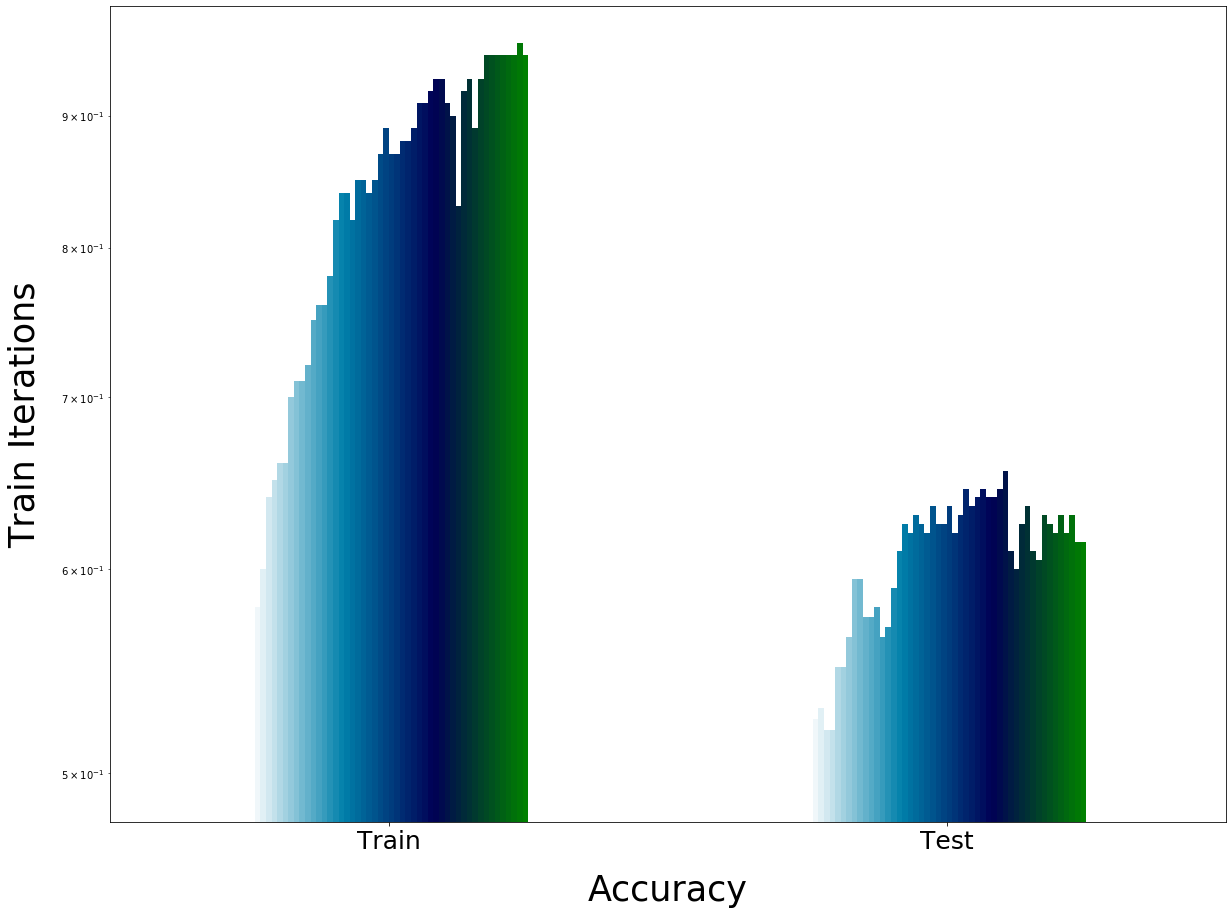

In [24]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0.5)
results_df_1.plot(kind='bar', legend = False, figsize=(20,15), logy=True, colormap='ocean_r', ax = ax)
#ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.6)

ax.set_xlabel( 'Accuracy', rotation=0, fontsize=35, labelpad=20)
ax.set_ylabel( 'Train Iterations', rotation=90, fontsize=35, labelpad=20)

for label in ax.get_xticklabels():
  label.set_rotation(0)
  label.set_size(25)
        
plt.show()

In [25]:
%%time
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up
n_layers = 3

learning_rate = 0.0001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 50
batch_size = 100

results = {}

batch_results_raw = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            batch_results_raw.append( 'Batch {} training observations from {} to '.format( iteration, iteration*batch_size, (iteration + 1)*batch_size-1))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        results[epoch] = {'Train' : acc_train, 'Test' : acc_test}

results_df_2 = pd.DataFrame.from_dict(results)
results_df_2

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Wall time: 38.6 s


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Train,0.47,0.52,0.57,0.61,0.61,0.610,0.62,0.680,0.690,0.670,...,0.760,0.770,0.770,0.780,0.780,0.78,0.79,0.790,0.80,0.80
Test,0.53,0.54,0.55,0.52,0.55,0.545,0.57,0.565,0.555,0.545,...,0.665,0.665,0.665,0.665,0.655,0.66,0.66,0.655,0.65,0.65


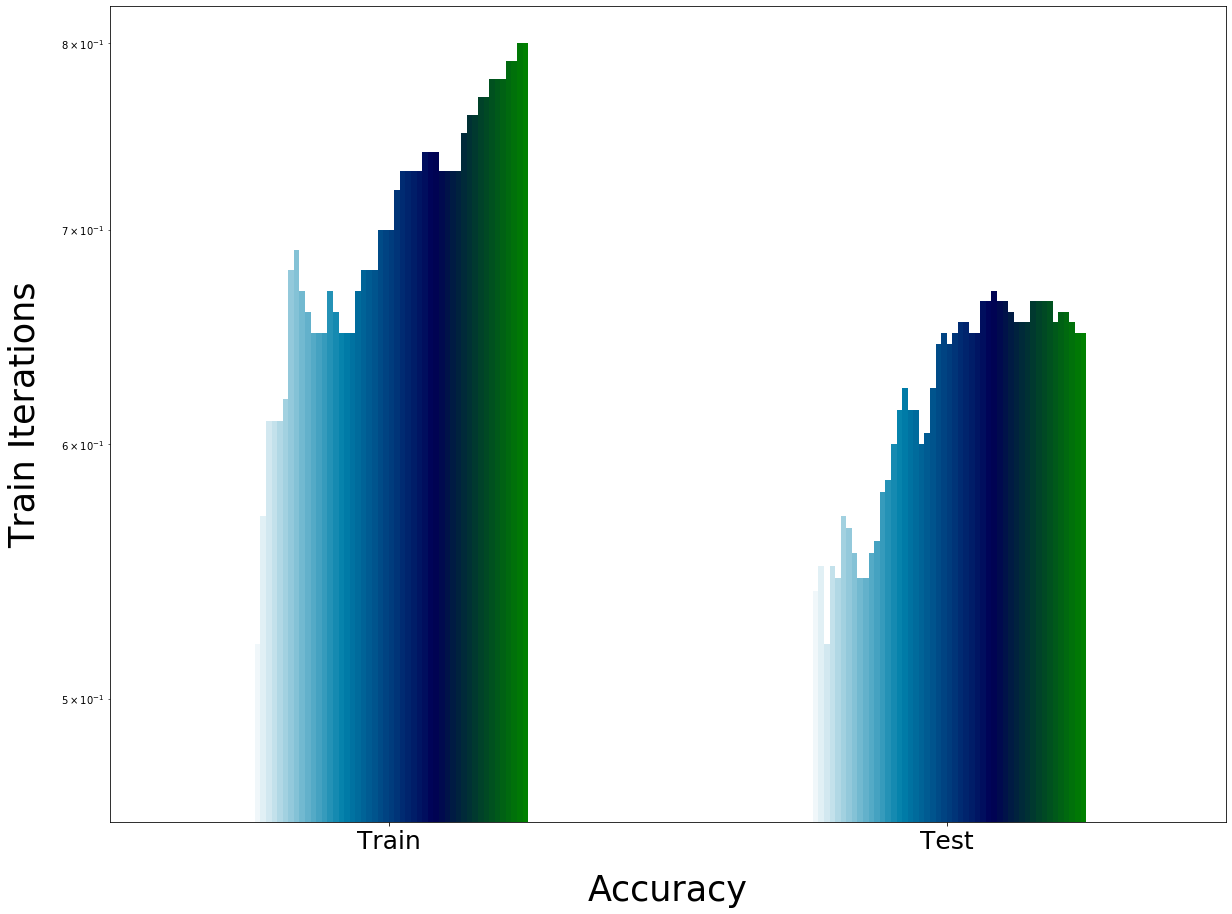

In [26]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0.5)
results_df_2.plot(kind='bar', legend = False, figsize=(20,15), logy=True, colormap='ocean_r', ax = ax)
#ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.6)

ax.set_xlabel( 'Accuracy', rotation=0, fontsize=35, labelpad=20)
ax.set_ylabel( 'Train Iterations', rotation=90, fontsize=35, labelpad=20)

for label in ax.get_xticklabels():
  label.set_rotation(0)
  label.set_size(25)
        
plt.show()

In [27]:
%%time
reset_graph()

# lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up
n_layers = 3

learning_rate = 0.01

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

keep_prob = tf.placeholder_with_default(.5, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
        
n_epochs = 100
batch_size = 100

results = {}

batch_results_raw = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            batch_results_raw.append( 'Batch {} training observations from {} to '.format( iteration, iteration*batch_size, (iteration + 1)*batch_size-1))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        results[epoch] = {'Train' : acc_train, 'Test' : acc_test}

results_df_3 = pd.DataFrame.from_dict(results)
results_df_3

Wall time: 1min 8s


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Train,0.48,0.61,0.54,0.64,0.640,0.660,0.71,0.680,0.67,0.67,...,0.900,0.810,0.82,0.82,0.800,0.780,0.880,0.87,0.840,0.82
Test,0.58,0.54,0.50,0.55,0.595,0.545,0.63,0.575,0.53,0.54,...,0.605,0.595,0.59,0.63,0.625,0.625,0.625,0.62,0.625,0.63


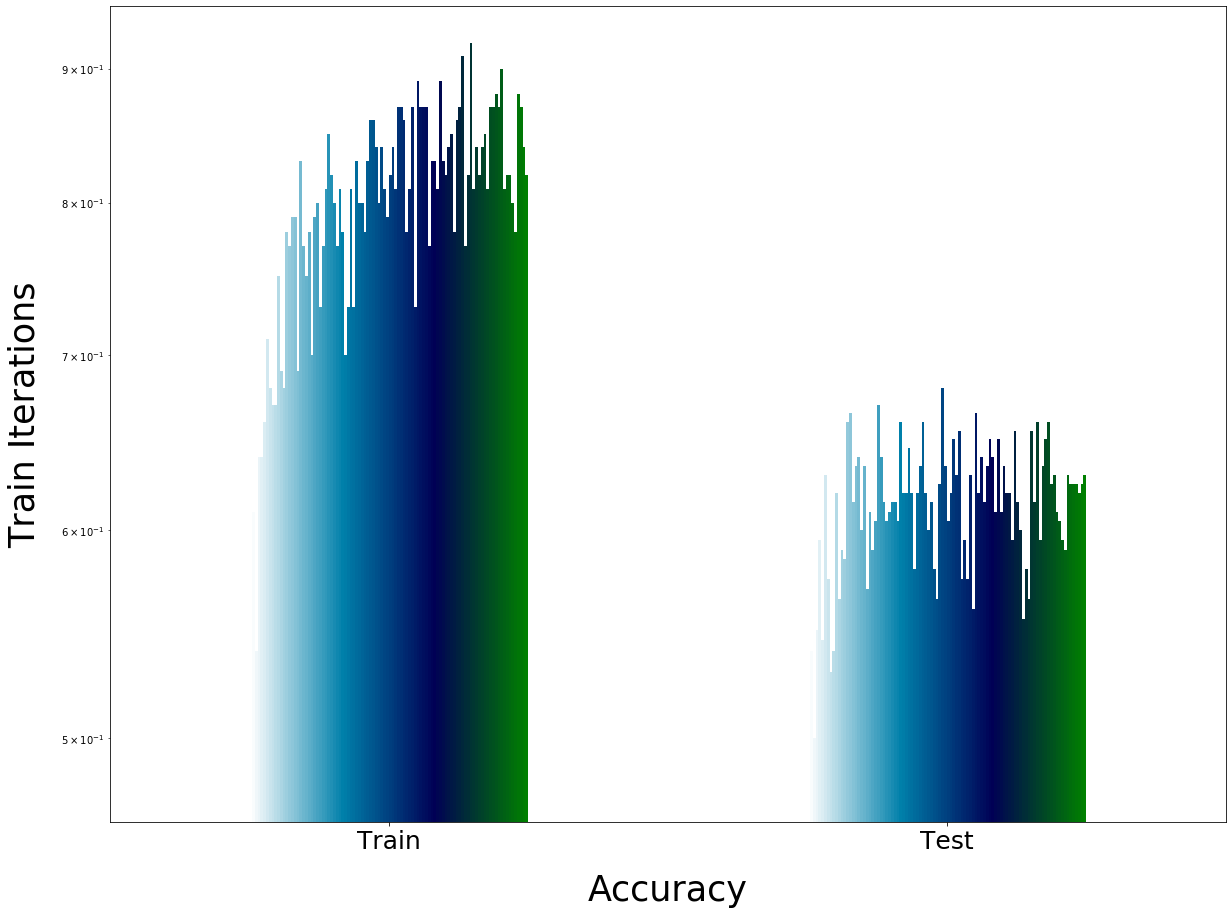

In [28]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0.5)
results_df_3.plot(kind='bar', legend = False, figsize=(20,15), logy=True, colormap='ocean_r', ax = ax)
#ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.6)

ax.set_xlabel( 'Accuracy', rotation=0, fontsize=35, labelpad=20)
ax.set_ylabel( 'Train Iterations', rotation=90, fontsize=35, labelpad=20)

for label in ax.get_xticklabels():
  label.set_rotation(0)
  label.set_size(25)
        
plt.show()